## Notebook to inspect and analyse CDAW catalog

The CDAW csv file read into a pandas DataFrame here is created in `get_cdaw.py` by reading the univseral CDAW txt file catalog.

A full description of the CDAW catalog is here https://cdaw.gsfc.nasa.gov/CME_list/catalog_description.htm

But here's a summary of column descriptions:

* `date` : Date of first appearance of CME 
* `time` : Time of first appearance of CME in LASCO C2 field of view
* `central_pa` : Central position angle. Halo CMEs have an apparent width of 360$^{\circ}$ and hence are marked as "halo" rather than given an angle.
* `width` : sky-plane width of CME, typically measured in C2. Further detailed on when the width was measured can be found in associated txt files (not in this csv file).
* `linear_speed` : the linear speed obtained by fitting a straight line to the height-time measurements,
* `2nd_order_speed_inital` : quadratic speed obtained by fitting a parabola to the height-time measurements and evaluating the speed at the time of initial height measurement
* `2nd_order_speed_final` : same as previous but evaluated at final height measurement
* `2nd_order_speed_20R` : same as previous but evaluated at 20 solar radii

* `accel` : acceleration, can be positive, negative or 0. At least three measurements are required, if only three are used an * is also included with the value.
* `mass` :  estimation of CME mass involves a number of assumptions, so the values given should be taken as representative, and marked with * is large uncertainty associated with it.
* `kinetic_energy` : kinetic energy is obtained from the linear speed and the representative mass. Again also very uncertain - large uncertainties marked with * too.
* `MPA` : measurement position angle, he position angle at which the height-time measurements are made. In ideal case MPA and central_pa should be the same, however some CMEs move non-radially and so these do not coincide. For halo CMEs a MPA is given and this refers to the fastest moving front of the leading edge.
* `remarks` : notes quality of observation and some notes referring to detection
* `quality_index` : this is the index that I pulled from each individual event text files, and denotes the quality of the observation with 0 being the worse (ill-defined) to 5 (excellent)

Some notes on the associated txt file:

" _We regard the linear speed, width, CPA, and acceleration as the basic attributes of a CME. The text file linked to the first appearance time contains the actual height-time measurements, which may be useful for over plotting with other data. The text file also contains the CME onset times obtained by extrapolating the linear fit (#ONSET1) or quadratic fit (#ONSET2) to the solar surface (height = 1 solar radius). Note that theses extrapolations are accurate only for limb events. For disk events, the estimated onset is likely to be after the actual onset time. There is a quality index listed in the text file for each CME, on a scale of 1-5, 1 being poor and 5 being excellent._"

In [28]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sunpy.coordinates import frames
from sunpy.sun import constants
from astropy import units as u 
from astropy.coordinates import SkyCoord, CylindricalRepresentation
import sunpy.map 

In [29]:
R_sun = constants.radius

In [30]:
cdaw = pd.read_csv("cdaw_2010_2018_w_quality.csv")
cdaw.keys()

Index(['date', 'time', 'central_pa', 'width', 'linear_speed',
       '2nd_order_speed_inital', '2nd_order_speed_final',
       '2nd_order_speed_20R', 'accel', 'mass', 'kinetic_energy', 'MPA',
       'remarks', 'time_c2', 'quality_index'],
      dtype='object')

In [31]:
cdaw.head(3)

,date,time,central_pa,width,linear_speed,2nd_order_speed_inital,2nd_order_speed_final,2nd_order_speed_20R,accel,mass,kinetic_energy,MPA,remarks,time_c2,quality_index
0,2010/01/01,06:54:03,354,6,330,269,396,959,35.5*,-------,-------,355,Very Poor Event; Only 3 points; Only C2,2010-01-01 06:54:03,#QUALITY_INDEX: 0 (Ill-Defined)
1,2010/01/01,08:30:03,248,75,148,60,244,220,1.9*,4.2e+14,4.6e+28,253,Poor Event,2010-01-01 08:30:03,#QUALITY_INDEX: 1 (Poor)
2,2010/01/01,17:06:03,49,21,729,764,694,700,-3.9,4.0e+14,1.1e+30,52,NaN,2010-01-01 17:06:03,#QUALITY_INDEX: 3 (Typical)


In [32]:
cdaw.keys()

Index(['date', 'time', 'central_pa', 'width', 'linear_speed',
       '2nd_order_speed_inital', '2nd_order_speed_final',
       '2nd_order_speed_20R', 'accel', 'mass', 'kinetic_energy', 'MPA',
       'remarks', 'time_c2', 'quality_index'],
      dtype='object')

In [33]:
cdaw.time_c2 = pd.to_datetime(cdaw.time_c2)

In [34]:
cdaw["quality_index"].unique()

array(['#QUALITY_INDEX: 0 (Ill-Defined)', '#QUALITY_INDEX: 1 (Poor)',
       '#QUALITY_INDEX: 3 (Typical)', '#QUALITY_INDEX: 2 (Fair)',
       '#QUALITY_INDEX: 4 (Good)', '#QUALITY_INDEX: 5 (Excellent)', nan,
       '#QUALITY_INDEX: -1 (Not assigned)'], dtype=object)

In [35]:
cdaw[cdaw["quality_index"].isnull()].tail()

,date,time,central_pa,width,linear_speed,2nd_order_speed_inital,2nd_order_speed_final,2nd_order_speed_20R,accel,mass,kinetic_energy,MPA,remarks,time_c2,quality_index
12660,2016/04/12,03:36:04,88,92,155,94,218,359,4.9,1.1e+15,1.3e+29,92,NaN,2016-04-12 03:36:04,NaN
12717,2016/04/24,23:24:04,Halo,360,381,308,454,959,33.9*,5.5e+12*,4.0e+27*,164,Poor Event; Only C2,2016-04-24 23:24:04,NaN
13621,2017/02/01,06:36:06,346,101,76,53,103,240,2.4*,4.2e+14,1.2e+28,360,Only C2,2017-02-01 06:36:06,NaN
13622,2017/02/01,14:48:05,342,143,279,0,591,570,15.1*,4.4e+15*,1.7e+30*,320,Partial Halo,2017-02-01 14:48:05,NaN
14104,2017/09/04,19:00:05,233,205,597,436,762,1216,52.9,4.9e+15*,8.6e+30*,240,Uncertain Width; Partial Halo,2017-09-04 19:00:05,NaN


In [36]:
len(cdaw[cdaw["quality_index"].isnull()])

48

Lets just drop nan values (worry about this later, but its only like 48 events so grande punto.

In [38]:
cdaw = cdaw.dropna(subset=['quality_index'])

In [39]:
cdaw["quality_val"] = [int(x.split()[1]) for x in cdaw["quality_index"]]

In [45]:
cdaw["quality_val"].unique()[-1]

-1

In [47]:
cdaw["quality_val"].value_counts()

 1    5604
 0    4908
 2    2630
 3     836
 4     477
 5     308
-1       1
Name: quality_val, dtype: int64

So basically any event with a `quality_val` >= 3 is noted as a "good" event. Lets just focus on these

In [40]:
print("The number of `good` events is {:d} from the full list of {:d} events" \
      .format(np.sum(cdaw["quality_val"]>=3),
      len(cdaw)))

The number of `good` events is 1621 from the full list of 14764 events


In [13]:
cdaw_final = cdaw[cdaw["quality_val"]>=3]

In [14]:
cdaw_final.keys()

Index(['date', 'time', 'central_pa', 'width', 'linear_speed',
       '2nd_order_speed_inital', '2nd_order_speed_final',
       '2nd_order_speed_20R', 'accel', 'mass', 'kinetic_energy', 'MPA',
       'remarks', 'time_c2', 'quality_index', 'quality_val'],
      dtype='object')

<AxesSubplot:xlabel='central_pa'>

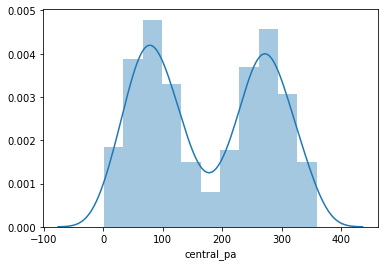

In [15]:
central_pa = cdaw_final["central_pa"]
sns.distplot(central_pa.replace("Halo", np.nan))

<AxesSubplot:xlabel='width'>

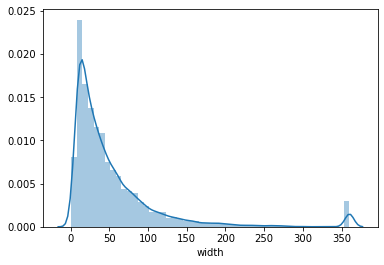

In [16]:
sns.distplot(cdaw["width"].astype(float))

<AxesSubplot:xlabel='linear_speed'>

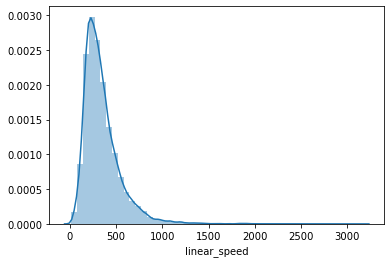

In [17]:
sns.distplot(cdaw["linear_speed"].astype(float))

<AxesSubplot:xlabel='MPA'>

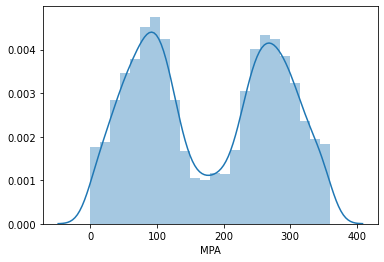

In [18]:
sns.distplot(cdaw["MPA"].astype(float))

<AxesSubplot:xlabel='2nd_order_speed_20R'>

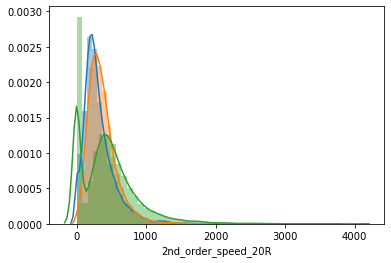

In [19]:
sns.distplot(cdaw["2nd_order_speed_inital"].replace("----", np.nan).astype(float))
sns.distplot(cdaw["2nd_order_speed_final"].replace("----", np.nan).astype(float))
sns.distplot(cdaw["2nd_order_speed_20R"].replace("----", np.nan).astype(float))

In [20]:
mpa = cdaw["MPA"]*u.deg

In [21]:
cdaw["datetime"]= pd.to_datetime(cdaw["date"] + cdaw["time"], format="%Y/%m/%d%H:%M:%S")

In [22]:
hcc = SkyCoord(CylindricalRepresentation(2*R_sun, mpa, 0*u.km),
               frame=frames.Heliocentric(observer="earth", obstime=cdaw["datetime"]))

In [23]:
hpcc = hcc.transform_to(frames.Helioprojective)

<CoordinatesMap with 2 world coordinates:

  index aliases    type   unit wrap format_unit visible
  ----- ------- --------- ---- ---- ----------- -------
      0     lon longitude  deg  180         deg     yes
      1     lat  latitude  deg None         deg     yes

>

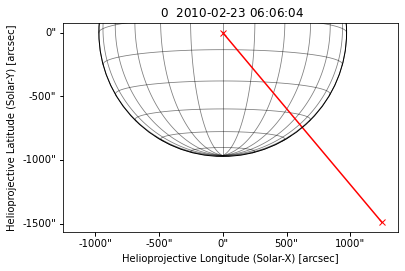

In [24]:
i=120
ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=frames.Helioprojective(observer="earth", obstime=hpcc[i].obstime))
my_header = sunpy.map.make_fitswcs_header(np.zeros((25, 25)), ref_coord, scale=[100, 100]*u.arcsec/u.pixel)
my_map = sunpy.map.Map(np.zeros((10, 10)), my_header)


center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=frames.Helioprojective, obstime=hpcc[i].obstime, observer="earth")
my_map.plot(alpha=0)
my_map.draw_limb(color="k")
ax = plt.gca()
ax.plot_coord(SkyCoord((center, hpcc[i])), marker='x', color="r")
my_map.draw_grid(color="k", annotate=False)

(array([1030., 1834., 2461., 1581.,  577.,  637., 1617., 2268., 1737.,
        1022.]),
 array([  0.,  36.,  72., 108., 144., 180., 216., 252., 288., 324., 360.]),
 <BarContainer object of 10 artists>)

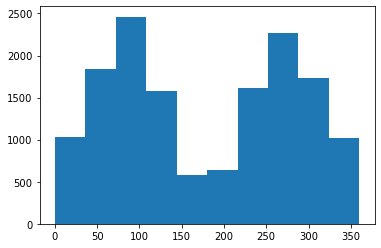

In [25]:
plt.hist(mpa)